# Model

In [1]:
import pandas as pd
import scipy as sc
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
#!pip install keras
from keras.optimizers import adam_v2 as Adam
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score, recall_score, precision_score
from sklearn.metrics import  confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import class_weight
from sklearn import preprocessing
import keras.metrics
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion, Pipeline
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Ebay corpus

In [3]:
eBay = pd.read_csv('/content/drive/MyDrive/Notebookfiles/ebay.csv',index_col=0) #load data
eBay

,title,description
1,"Google Hacking for Penetration Testers, Volume 1","Google, the most popular search engine worldwi..."
2,"Hacking Roomba: ExtremeTech, Tod E. Kurt, Good...",The Jetsons would be proud! A gizmo as cool as...
3,OURS TO HACK AND TO OWN By Emma Jane Kirby,Real democracy and the Internet are not mutual...
4,Hacking : The Hacking for Beginners Guide to C...,Are You Looking To Learn About Hacking & Infor...
5,Spotify Premium Account Lifetime New Account o...,Spotify Premium Lifetime account for a new acc...
...,...,...
96,"email list USA, USA consumer email list, USA b...","Email list USA, USA consumer email list, USA b..."
97,"Email DATABASE List New Business Marketing,wor...","Email Database to increase your customers, pro..."
98,Funimation Premium Account Subscription | Life...,Terms Of Service\nSharing or reselling is forb...
99,Pokemon Account Go Level 35 - 36 Premium - Gym...,"Level 35-36 Premium Account\n✔ Good account, N..."


### Defining various popuarity labels

In [24]:
df = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/df.pkl")
popularity_thresholdC9 = df.sold.quantile(0.9)
popularity_thresholdC8 = df.sold.quantile(0.8)
popularity_thresholdC7 = df.sold.quantile(0.7)
popularity_thresholdV9 = df.turnover.quantile(0.9)
popularity_thresholdV8 = df.turnover.quantile(0.8)
popularity_thresholdV7 = df.turnover.quantile(0.7)

df = df.loc[((df['market'] == 'darkfox') | (df['market'] == 'versus') | (df['market'] == 'deepsea') | (df['market'] == 'empire') | (df['market'] == 'darknet')) & (df['Lang'] == 'en')][['price', 'title', 'description', 'sold', 'turnover']]
df.loc[df['sold'] < popularity_thresholdC9, 'C9'] = 0 
df.loc[df['sold'] >= popularity_thresholdC9, 'C9'] = 1
df.loc[df['sold'] < popularity_thresholdC8, 'C8'] = 0 
df.loc[df['sold'] >= popularity_thresholdC8, 'C8'] = 1
df.loc[df['sold'] < popularity_thresholdC7, 'C7'] = 0 
df.loc[df['sold'] >= popularity_thresholdC7, 'C7'] = 1
df.loc[df['turnover'] < popularity_thresholdV9, 'V9'] = 0 
df.loc[df['turnover'] >= popularity_thresholdV9, 'V9'] = 1
df.loc[df['turnover'] < popularity_thresholdV8, 'V8'] = 0 
df.loc[df['turnover'] >= popularity_thresholdV8, 'V8'] = 1
df.loc[df['turnover'] < popularity_thresholdV7, 'V7'] = 0 
df.loc[df['turnover'] >= popularity_thresholdV7, 'V7'] = 1
df

,price,title,description,sold,turnover,C9,C8,C7,V9,V8,V7
9311,80.00,USA CREDIT HQ DUMBPS FULL INFO HIGH BALANCE TR...,USA CREDIT HQ DUMBPS FULL INFO HIGH BALANCE TR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9312,400.00,WORLDWIDE CHOOSE YOU COUNTRY CREDIT HQ DUMBPS ...,WORLDWIDE CHOOSE YOU COUNTRY CREDIT HQ DUMBPS ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9313,9.00,🦊⭐💳DUMPS+ PIN PACK TR1+TR2 PACKAGE TUTORIAL IN...,DUMPS+ PIN PACK TR1+TR2 PACKAGE TUTORIAL INSTA...,2.0,18.0,0.0,0.0,1.0,0.0,0.0,1.0
9314,24.99,Walgreens Pharmacy Prescription Label PSD Temp...,Walgreens Pharmacy Prescription Label PSD Temp...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9315,9.99,Sweden Drivers License PSD Template,Sweden Drivers License PSD Template\n\nOur pro...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
31162,9.99,Aternos.org Database 1.2 Million Records,Aternos.org Database 1.2 Million Records\n\nIn...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31163,9.99,Xiaomi Database 7 Million Records,Xiaomi Database 7 Million Records\n\nIncluded ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31164,9.99,Dubsmash Database 162 Million Records,Dubsmash Database 162 Million Records\n\nInclu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31165,4.50,CIA BOOK OF DIRTY TRICKS,CIA BOOK OF DIRTY TRICKS\nAdditives\nAirlines\...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
dfUnlabeled = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/df.pkl")
dfUnlabeled = dfUnlabeled.loc[((dfUnlabeled['market'] != 'darkfox') & (dfUnlabeled['market'] != 'versus') & (dfUnlabeled['market'] != 'deepsea') & (dfUnlabeled['market'] != 'empire') & (dfUnlabeled['market'] != 'darknet')) & (dfUnlabeled['Lang'] == 'en')][['price', 'title', 'description']]
dfUnlabeled

,price,title,description
0,9.55,timfuck.treasureislandmedia.com Porn Premium A...,"The gay men here are of the manly variety, wit..."
1,476.35,10 UK bet365 verified accounts,10 UK bet365 verified accounts
2,5.00,Masterclass All Access Plan + Annual Pass + Au...,Masterclass All Access Plan + Annual Pass + Au...
3,28.00,Canada PASSPORT PSD TEMPLATE 19 LAYERS SCAN,This listing include very very high quality NE...
4,10.00,Pokebir.com Database (Plaintext),Pokebir.com Database (Plaintext)\n\nWhy Buy fr...
...,...,...,...
23687,1.54,Advanced Lock Picking Secrets -Instant Delivery,IMPORTANT!\n-100% Guarantee! if the method/sof...
23692,10.25,Poland Drivers License PSD Template,Poland Drivers License PSD Template\n\nOur pro...
23693,5.11,Norway FULLZ CC Credit Card - Norway FULLZ CC ...,Norway FULLZ CC Credit Card - Norway FULLZ CC ...
23697,10.25,"1,42 Million United Kingdom Leads","1,42 Million United Kingdom Leads\n\nWe promis..."


In [ ]:
df.groupby(['popular']).size()

### Preprocessing

In [18]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def remove_emoji(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                u"\U00010000-\U0010ffff"
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_text(sen):
    
    # Remove words with numbers
    sentence = re.sub(r'\w*\d\w*',' ', sen)
    
    # Remove url
    sentence = re.sub(r'https?://\S+|www\.\S+',' ',sentence)
    
    # Remove html
    sentence = re.sub(r'<.*?>',' ',sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Lowercasing
    sentence = sentence.lower()

    # Tokenization
    #word_list = nltk.word_tokenize(sentence)

    # Lemmatization
    #sentence = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    # Tokenization 2
    #word_list = nltk.word_tokenize(sentence)

    #stopword removal
    #sentence = ' '.join([word for word in word_list if not word in stopwords.words('english')])


    return sentence

In [25]:
df['title'] = df['title'].apply(lambda x : remove_emoji(x))
df['title'] = df['title'].apply(lambda x : preprocess_text(x))

df['description'] = df['description'].apply(lambda x : remove_emoji(x))
df['description'] = df['description'].apply(lambda x : preprocess_text(x))
df['both'] = df['title'].astype(str) + " " + df['description'].astype(str)

#df = df.sample(frac=1)
df

,price,title,description,sold,turnover,C9,C8,C7,V9,V8,V7,both
9311,80.00,usa credit hq dumbps full info high balance,usa credit hq dumbps full info high balance we...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,usa credit hq dumbps full info high balance u...
9312,400.00,worldwide choose you country credit hq dumbps ...,worldwide choose you country credit hq dumbps ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,worldwide choose you country credit hq dumbps ...
9313,9.00,dumps pin pack package tutorial instant delivery,dumps pin pack package tutorial instant delive...,2.0,18.0,0.0,0.0,1.0,0.0,0.0,1.0,dumps pin pack package tutorial instant delive...
9314,24.99,walgreens pharmacy prescription label psd temp...,walgreens pharmacy prescription label psd temp...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,walgreens pharmacy prescription label psd temp...
9315,9.99,sweden drivers license psd template,sweden drivers license psd template our promis...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sweden drivers license psd template sweden dri...
...,...,...,...,...,...,...,...,...,...,...,...,...
31162,9.99,aternos org database million records,aternos org database million records included ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aternos org database million records aternos o...
31163,9.99,xiaomi database million records,xiaomi database million records included infor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,xiaomi database million records xiaomi databas...
31164,9.99,dubsmash database million records,dubsmash database million records included inf...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dubsmash database million records dubsmash dat...
31165,4.50,cia book of dirty tricks,cia book of dirty tricks additives airlines an...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cia book of dirty tricks cia book of dirty tri...


### Select similar samples for onion corpus for comaparison to ebay corpus

In [44]:
dfCompare = df[['title', 'description', 'both']].copy()
dfCompare = dfCompare.loc[dfCompare['both'].str.contains('software|premium|premium account|account|vpn|psd|fraud|gift card|giftcard|gift|card|email|e mail|mail|template|hack|hacked|hacking|how to|guide|book|malware') & ~dfCompare['both'].str.contains('porn|sex|id|passport|drivers license|credit|credit card|product description') ]
dfCompare = dfCompare.sample(n = 100)
dfCompare['legal'] = 0
dfCompare

,title,description,both,legal
9682,fast paypal transfer service,this offer is for those who want to make real ...,fast paypal transfer service this offer is for...,0
29831,younow leaked hacked dtabase records,younow appeared for sale on dark web marketpla...,younow leaked hacked dtabase records younow a...,0
28018,million hotmail emails,million hotmail emails we promise your order ...,million hotmail emails million hotmail email...,0
25237,codeacademy pro accounts learn to code auto de...,codecademy learn to code for free please be aw...,codeacademy pro accounts learn to code auto de...,0
24712,com premium account instant delivery,com premium account instant delivery https com,com premium account instant delivery com pre...,0
...,...,...,...,...
29260,pack ssn bank records,hi you will receive pack extras may be include...,pack ssn bank records hi you will receive pac...,0
29270,new aged google yahoo accounts clone,new aged google yahoo accounts dear patrons d...,new aged google yahoo accounts clone new ag...,0
10311,million brazil emails leads,million brazil emails leads we promise your o...,million brazil emails leads million brazil e...,0
29745,turk internet leacked hacked database record,exposing rows of customer data compromised dat...,turk internet leacked hacked database record ...,0


### Ebay corpus preprocessing

In [ ]:
eBay['title'] = eBay['title'].apply(lambda x : remove_emoji(x))
eBay['title'] = eBay['title'].apply(lambda x : preprocess_text(x))

eBay['description'] = eBay['description'].apply(lambda x : remove_emoji(x))
eBay['description'] = eBay['description'].apply(lambda x : preprocess_text(x))
eBay['both'] = eBay['title'].astype(str) + " " + eBay['description'].astype(str)

#eBay = eBay.sample(frac=1)


In [45]:
eBay['legal'] = 1

In [ ]:
Comparison = pd.concat([eBay, dfCompare], ignore_index=True, sort=False)
Comparison = Comparison.sample(frac=1)

In [48]:
from nltk.tag import pos_tag, map_tag
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

### Apply multiple data transformations

In [49]:
#nltk.download('averaged_perceptron_tagger')
Comparison['POS'] = Comparison['both']
Comparison['POS'] = Comparison['POS'].apply(lambda x : nltk.pos_tag(word_tokenize(x)))
Comparison['POS'] = Comparison['POS'].apply(lambda x : [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in x])
Comparison

,title,description,both,legal,POS
189,fresh cvv usa american express hq know balance...,greetings before hand friends read before buyi...,fresh cvv usa american express hq know balance...,0,"[(fresh, ADJ), (cvv, NOUN), (usa, ADJ), (ameri..."
100,fast paypal transfer service,this offer is for those who want to make real ...,fast paypal transfer service this offer is for...,0,"[(fast, ADV), (paypal, ADJ), (transfer, NOUN),..."
95,email list usa usa consumer email list usa dat...,email list usa usa consumer email list usa dat...,email list usa usa consumer email list usa dat...,1,"[(email, ADJ), (list, NOUN), (usa, ADJ), (usa,..."
152,million turkey emails leads,million turkey emails leads we promise your o...,million turkey emails leads million turkey e...,0,"[(million, NUM), (turkey, NOUN), (emails, VERB..."
36,openvpn vpn service month subscription free sh...,introducing low cost openvpn vpn service use w...,openvpn vpn service month subscription free sh...,1,"[(openvpn, ADV), (vpn, ADJ), (service, NOUN), ..."
...,...,...,...,...,...
175,how to succesfully card on amazon,how to card on amazon easy and secure way to c...,how to succesfully card on amazon how to card ...,0,"[(how, ADV), (to, PRT), (succesfully, ADV), (c..."
178,youtube account creator updated,a great youtube account creator very easy to u...,youtube account creator updated a great youtu...,0,"[(youtube, NOUN), (account, NOUN), (creator, N..."
132,wayfair giftcard carding method,the steps by steps instructions on how to card...,wayfair giftcard carding method the steps by s...,0,"[(wayfair, NOUN), (giftcard, NOUN), (carding, ..."
89,the crypto book how to invest safely in bitcoi...,the monster bookshop is an online bookshop est...,the crypto book how to invest safely in bitcoi...,1,"[(the, DET), (crypto, NOUN), (book, NOUN), (ho..."


In [67]:
Comparison['RC'] = Comparison['POS'].apply(lambda x : ' '.join([pos[0] for pos in x if pos[1] not in ('ADJ','ADV','NOUN','PROPN','VERB','X','NUM')] ) )

In [68]:
Comparison['RF'] = Comparison['POS'].apply(lambda x : ' '.join([pos[0] for pos in x if pos[1] in ('ADJ','ADV','NOUN','PROPN','VERB','X','NUM')] ) )

In [93]:
Comparison['CP'] = Comparison['POS'].apply(lambda x : ' '.join([pos[0] for pos in [((pos[1],pos[1]) if pos[1] in ('ADJ','ADV','NOUN','PROPN','VERB','X','NUM') else (pos[0],pos[1])) for pos in x ]]) )

In [94]:
Comparison['FP'] = Comparison['POS'].apply(lambda x : ' '.join([pos[0] for pos in [((pos[1],pos[1]) if pos[1] not in ('ADJ','ADV','NOUN','PROPN','VERB','X','NUM') else (pos[0],pos[1])) for pos in x ]]) )

In [95]:
Comparison

,title,description,both,legal,POS,RC,RF,CP,FP
189,fresh cvv usa american express hq know balance...,greetings before hand friends read before buyi...,fresh cvv usa american express hq know balance...,0,"[(fresh, ADJ), (cvv, NOUN), (usa, ADJ), (ameri...",to before before the all the that and by it in...,fresh cvv usa american express hq know balance...,ADJ NOUN ADJ ADJ NOUN NOUN VERB NOUN to VERB N...,fresh cvv usa american express hq know balance...
100,fast paypal transfer service,this offer is for those who want to make real ...,fast paypal transfer service this offer is for...,0,"[(fast, ADV), (paypal, ADJ), (transfer, NOUN),...",this for those who to and to in it through we ...,fast paypal transfer service offer is want mak...,ADV ADJ NOUN NOUN this NOUN VERB for those who...,fast paypal transfer service DET offer is ADP ...
95,email list usa usa consumer email list usa dat...,email list usa usa consumer email list usa dat...,email list usa usa consumer email list usa dat...,1,"[(email, ADJ), (list, NOUN), (usa, ADJ), (usa,...",per for aus and and no no and you within of yo...,email list usa usa consumer email list usa dat...,ADJ NOUN ADJ ADJ NOUN NOUN NOUN ADJ NOUN VERB ...,email list usa usa consumer email list usa dat...
152,million turkey emails leads,million turkey emails leads we promise your o...,million turkey emails leads million turkey e...,0,"[(million, NUM), (turkey, NOUN), (emails, VERB...",we your if you with your we your,million turkey emails leads million turkey ema...,NUM NOUN VERB VERB NUM NOUN NOUN VERB we VERB ...,million turkey emails leads million turkey ema...
36,openvpn vpn service month subscription free sh...,introducing low cost openvpn vpn service use w...,openvpn vpn service month subscription free sh...,1,"[(openvpn, ADV), (vpn, ADJ), (service, NOUN), ...",any no to about by any any up each among each ...,openvpn vpn service month subscription free sh...,ADV ADJ NOUN NOUN NOUN ADJ NOUN NOUN ADJ VERB ...,openvpn vpn service month subscription free sh...
...,...,...,...,...,...,...,...,...,...
175,how to succesfully card on amazon,how to card on amazon easy and secure way to c...,how to succesfully card on amazon how to card ...,0,"[(how, ADV), (to, PRT), (succesfully, ADV), (c...",to on to on and to on with this you you,how succesfully card amazon how card amazon ea...,ADV to ADV VERB on ADJ ADV to VERB on ADJ ADJ ...,how PRT succesfully card ADP amazon how PRT ca...
178,youtube account creator updated,a great youtube account creator very easy to u...,youtube account creator updated a great youtu...,0,"[(youtube, NOUN), (account, NOUN), (creator, N...",a to after,youtube account creator updated great youtube ...,NOUN NOUN NOUN VERB a ADJ NOUN NOUN NOUN ADV A...,youtube account creator updated DET great yout...
132,wayfair giftcard carding method,the steps by steps instructions on how to card...,wayfair giftcard carding method the steps by s...,0,"[(wayfair, NOUN), (giftcard, NOUN), (carding, ...",method the by on to the on,wayfair giftcard carding steps steps instructi...,NOUN NOUN VERB method the NOUN by NOUN NOUN on...,wayfair giftcard carding DET DET steps ADP ste...
89,the crypto book how to invest safely in bitcoi...,the monster bookshop is an online bookshop est...,the crypto book how to invest safely in bitcoi...,1,"[(the, DET), (crypto, NOUN), (book, NOUN), (ho...",the to in and the an in to on and over we of f...,crypto book how invest safely bitcoin other cr...,the NOUN NOUN ADV to VERB ADV in NOUN and ADJ ...,DET crypto book how PRT invest safely ADP bitc...


In [96]:
Comparison.to_pickle("/content/drive/MyDrive/Notebookfiles/Comparison.pkl")

In [197]:
Comparison = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Comparison.pkl")

In [198]:
Train, Test = np.split(Comparison, [int(.75*len(Comparison))])
Test.groupby(['legal']).size()

legal
0    23
1    27
dtype: int64

### Preprocess unlabaled data

In [ ]:
dfUnlabeled['title'] = dfUnlabeled['title'].apply(lambda x : remove_emoji(x))
dfUnlabeled['title'] = dfUnlabeled['title'].apply(lambda x : preprocess_text(x))

dfUnlabeled['description'] = dfUnlabeled['description'].apply(lambda x : remove_emoji(x))
dfUnlabeled['description'] = dfUnlabeled['description'].apply(lambda x : preprocess_text(x))
dfUnlabeled['both'] = dfUnlabeled['title'].astype(str) + " " + dfUnlabeled['description'].astype(str)

#df = df.sample(frac=1)
dfUnlabeled

In [16]:
dfUnlabeled['both'] = dfUnlabeled['title'].astype(str) + " " + dfUnlabeled['description'].astype(str)
dfUnlabeled = dfUnlabeled.sample(frac=1)
dfUnlabeled.to_pickle("/content/drive/MyDrive/Notebookfiles/Unlabeled.pkl")

In [79]:
df = df.sample(frac=1)
Train, Test = np.split(df, [int(.75*len(df))])
Test.groupby(['C9']).size()

C9
0.0    2769
1.0     365
dtype: int64

In [ ]:
Train.to_pickle("/content/drive/MyDrive/Notebookfiles/Train.pkl")
Test.to_pickle("/content/drive/MyDrive/Notebookfiles/Test.pkl")

In [71]:
Test
Test.groupby(['C9']).size()

C9
0.0    2823
1.0     311
dtype: int64

### Undersampling

In [661]:
def Undersampling(Train, popularity):
  TrainUnderSample = Train.loc[(Train[popularity] == 1) ].copy()
  undersampling = len(TrainUnderSample)
  TrainUnderSample = TrainUnderSample.append(Train.loc[(Train[popularity] == 0) ].sample(n = undersampling))
  TrainUnderSample = TrainUnderSample.sample(frac=1)
  return TrainUnderSample

### Oversampling

In [6]:
def Oversampling(Train, popularity):
  max_size = Train[popularity].value_counts().max()
  lst = []
  for class_index, group in Train.groupby(popularity):
      lst.append(group.sample(max_size-len(group), replace=True))
  frame_new = pd.concat(lst)
  Train = pd.concat([Train, frame_new])
  Train = Train.sample(frac=1)
  return Train

### Read data

In [ ]:
Train = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Train.pkl")
Test = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Test.pkl")
Unlabeled = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Unlabeled.pkl")

In [ ]:
popularity = 'legal'
x = 'both'

In [ ]:
Train = Oversampling(Train, popularity)

# BI-LSTM

### Embedding

In [8]:
def create_corpus(df):
    corpus=[]
    for sen in tqdm(df):
        words=[word.lower() for word in word_tokenize(sen) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [9]:
corpus=create_corpus(pd.concat([Train, Test])[x])

100%|██████████| 30875/30875 [00:14<00:00, 2163.92it/s]


In [16]:
embedding_dict={}
with open('/content/drive/MyDrive/Notebookfiles/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [17]:
MAX_LEN=500
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [18]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 29881


In [19]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 29881/29881 [00:00<00:00, 611956.90it/s]


In [20]:
embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,trainable=False)

In [21]:
model = Sequential()
model.add(embedding)
model.add(Bidirectional(LSTM(256, return_sequences=True))) 
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPooling1D()) 
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) 
#model.summary()


In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [46]:
X_train = Train[x]
X_test = Test[x]
#X_unlabeld = Unlabeled[x]

y_train = Train[popularity]
y_test = Test[popularity]

In [47]:


# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [48]:
X_train = pad[:X_train.shape[0]]
X_test = pad[:X_test.shape[0]]
#X_unlabeld2 = pad[:X_unlabeld.shape[0]]

In [27]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (12484, 500)
Shape of Validation  (3134, 500)


In [28]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([1., 1.])

In [29]:
#optimzer=Adam(learning_rate=1e-5)
optimzer = Adam.Adam(learning_rate= 1e-5)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), ]) 


In [30]:
model.fit(X_train, 
          y_train, 
          batch_size=32, 
          validation_split=0.2, 
          #validation_data=(X_test, y_test),
          epochs=100, 
          callbacks=callbacks,
#          verbose = 2,
 #         class_weight = {0: class_weights[0], 1: class_weights[1]}
          )


Epoch 1/100
40/40 [==============================] - 20s 281ms/step - loss: 0.7017 - accuracy: 0.5184 - recall: 0.5418 - precision: 0.5180 - val_loss: 0.6815 - val_accuracy: 0.6059 - val_recall: 0.7942 - val_precision: 0.5758

Epoch 00001: val_accuracy improved from -inf to 0.60593, saving model to weights121.h5
Epoch 2/100
40/40 [==============================] - 10s 247ms/step - loss: 0.6890 - accuracy: 0.5503 - recall: 0.5800 - precision: 0.5479 - val_loss: 0.6717 - val_accuracy: 0.6588 - val_recall: 0.6825 - val_precision: 0.6501

Epoch 00002: val_accuracy improved from 0.60593 to 0.65879, saving model to weights121.h5
Epoch 3/100
40/40 [==============================] - 10s 248ms/step - loss: 0.6801 - accuracy: 0.5697 - recall: 0.5628 - precision: 0.5712 - val_loss: 0.6627 - val_accuracy: 0.6672 - val_recall: 0.6921 - val_precision: 0.6578

Epoch 00003: val_accuracy improved from 0.65879 to 0.66720, saving model to weights121.h5
Epoch 4/100
40/40 [==============================] -

In [31]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("Test Recall:", score[2])
print("Test Precision:", score[3])
print("Test F1-score:", 2* ((score[2]*score[3])/(score[2]+score[3])))

98/98 [==============================] - 4s 44ms/step - loss: 0.9563 - accuracy: 0.4939 - recall: 0.4813 - precision: 0.3424
Test Score: 0.9562550187110901
Test Accuracy: 0.4939374625682831
Test Recall: 0.48134666681289673
Test Precision: 0.3423948287963867
Test F1-score: 0.40015128642562897


### for AUROC plot

In [63]:
predTemp=model.predict(X_test)

In [65]:
predTemp = np.around(predTemp)

In [73]:
fprB , tprB , thresholdsB = metrics.roc_curve ( y_test , predTemp)
roc_aucB = metrics.auc(fprB, tprB)

### Self learning 

In [128]:
pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Train.pkl").to_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")
zero = False
F1 = []
i = 0
X_unlabeld = Unlabeled['both']

while zero == False:
  weightsfile = 'weights' + str(i) + '.h5'
  keras.backend.clear_session()
  corpus=create_corpus(pd.concat([Train, Test, Unlabeled])['both'])

  embedding_dict={}
  with open('/content/drive/MyDrive/Notebookfiles/glove.6B.100d.txt','r') as f:
      for line in f:
          values=line.split()
          word=values[0]
          vectors=np.asarray(values[1:],'float32')
          embedding_dict[word]=vectors
  f.close()

  MAX_LEN=500
  tokenizer_obj=Tokenizer()
  tokenizer_obj.fit_on_texts(corpus)
  sequences=tokenizer_obj.texts_to_sequences(corpus)

  pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

  word_index=tokenizer_obj.word_index

  num_words=len(word_index)+1
  embedding_matrix=np.zeros((num_words,100))

  for word,i in tqdm(word_index.items()):
      if i > num_words:
          continue
      
      emb_vec=embedding_dict.get(word)
      if emb_vec is not None:
          embedding_matrix[i]=emb_vec

  embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                      input_length=MAX_LEN,trainable=False)

  model = Sequential()
  model.add(embedding)
  model.add(Bidirectional(LSTM(256, return_sequences=True))) 
  #model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
  #model.add(Dense(1024))
  #model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
  model.add(Dense(512))
  model.add(Dropout(0.25))
  model.add(Dense(256))
  model.add(Dropout(0.25))
  model.add(Dense(128))
  model.add(Dropout(0.25))
  model.add(Dense(64))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))

  callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=weightsfile,
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

  X_train = Train['both']
  X_test = Test['both']
  

  y_train = Train[popularity]
  y_test = Test[popularity]

  # label_encoder object knows how to understand word labels.
  label_encoder = preprocessing.LabelEncoder()

  # Encode labels in column 'species'.
  y_train = label_encoder.fit_transform(y_train)
  y_test = label_encoder.fit_transform(y_test)

  X_train = pad[:X_train.shape[0]]
  X_test = pad[:X_test.shape[0]]
  X_unlabeld2 = pad[:X_unlabeld.shape[0]]

  

  optimzer=Adam(learning_rate=1e-5)
  model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), ]) 
  #model.set_weights(weights)
  #print(model.get_weights()[2][5])
  model.fit(X_train, 
            y_train, 
            batch_size=32, 
            validation_split=0.2, 
            #validation_data=(X_test, y_test),
            epochs=10, 
            callbacks=callbacks,
            verbose = 0,
  #         class_weight = {0: class_weights[0], 1: class_weights[1]}
            )
  
  #model.set_weights(weights)

  score = model.evaluate(X_test, y_test, verbose=1)
  print(2* ((score[2]*score[3])/(score[2]+score[3])))
  F1.append(2* ((score[2]*score[3])/(score[2]+score[3])))

  #pred = model.predict(X_test)
  probU = model.predict(X_unlabeld2)

  dfprobU = pd.DataFrame(data=[probU.flatten(), X_unlabeld.to_numpy()], index=['prediction', 'both']).T
  dfprobU = dfprobU.loc[(dfprobU['prediction'] <= 0.05) | (dfprobU['prediction'] >= 0.95)]
  if len(dfprobU.index) > 0:
    dfprobU.loc[dfprobU['prediction'] < 0.5, popularity] = 0 
    dfprobU.loc[dfprobU['prediction'] >= 0.5, popularity] = 1

    Train = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")
    Train = pd.concat([Train, dfprobU[['both',popularity]]], ignore_index=True, sort=False)
    Train.to_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")
    Train = Oversampling(Train, popularity)

    X_unlabeld = X_unlabeld.reset_index(drop=True)
    X_unlabeld = pd.concat([X_unlabeld, dfprobU['both']]).drop_duplicates(keep=False)
    # X_unlabeld
    #dfprobU['both']


  print(len(dfprobU.index))
  zero = (len(dfprobU.index) == 0)

  print(len(dfprobU.index))
  zero = (len(dfprobU.index) == 0)
  i = i +1

100%|██████████| 29881/29881 [00:00<00:00, 571820.94it/s]



Epoch 00001: val_accuracy improved from -inf to 0.65038, saving model to weights0.h5

Epoch 00002: val_accuracy improved from 0.65038 to 0.66360, saving model to weights0.h5

Epoch 00003: val_accuracy improved from 0.66360 to 0.67361, saving model to weights0.h5

Epoch 00004: val_accuracy improved from 0.67361 to 0.68322, saving model to weights0.h5

Epoch 00005: val_accuracy did not improve from 0.68322

Epoch 00006: val_accuracy improved from 0.68322 to 0.68843, saving model to weights0.h5

Epoch 00007: val_accuracy improved from 0.68843 to 0.70404, saving model to weights0.h5

Epoch 00008: val_accuracy did not improve from 0.70404

Epoch 00009: val_accuracy improved from 0.70404 to 0.72127, saving model to weights0.h5

Epoch 00010: val_accuracy improved from 0.72127 to 0.72407, saving model to weights0.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.9053 - accuracy: 0.4812 - recall: 0.5296 - precision: 0.3442
0.41720430746276127
231
231


100%|██████████| 29881/29881 [00:00<00:00, 593755.91it/s]



Epoch 00001: val_accuracy improved from -inf to 0.61591, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.61591 to 0.65987, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65987 to 0.66507, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.66507 to 0.66986, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66986 to 0.68425, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68425 to 0.69544, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69544 to 0.70424, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.70424 to 0.70703, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70703 to 0.71623, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71623 to 0.72262, saving model to weights29882.h5
98/98 [==============================] - 3s 26ms/step - loss: 0.8558 - ac

100%|██████████| 29881/29881 [00:00<00:00, 557554.99it/s]



Epoch 00001: val_accuracy improved from -inf to 0.63843, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.63843 to 0.66600, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.66600 to 0.67040, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67040 to 0.68038, saving model to weights29882.h5

Epoch 00005: val_accuracy did not improve from 0.68038

Epoch 00006: val_accuracy improved from 0.68038 to 0.69397, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69397 to 0.69756, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69756 to 0.70875, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70875 to 0.70955, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.70955 to 0.71794, saving model to weights29882.h5
98/98 [==============================] - 2s 24ms/step - loss: 0.8576 - accuracy: 0.4860 - recall: 0.5032 - pre

100%|██████████| 29881/29881 [00:00<00:00, 579804.67it/s]



Epoch 00001: val_accuracy improved from -inf to 0.61262, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.61262 to 0.65695, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65695 to 0.66693, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.66693 to 0.67652, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.67652 to 0.68331, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68331 to 0.69529, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69529 to 0.70088, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.70088 to 0.70807, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70807 to 0.71046, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71046 to 0.72244, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8476 - ac

100%|██████████| 29881/29881 [00:00<00:00, 599949.25it/s]



Epoch 00001: val_accuracy improved from -inf to 0.57788, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.57788 to 0.64657, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.64657 to 0.65096, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65096 to 0.65136, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.65136 to 0.65895, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.65895 to 0.66294, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.66294 to 0.67013, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.67013 to 0.67053, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.67053 to 0.68131, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.68131 to 0.69369, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8429 - ac

100%|██████████| 29881/29881 [00:00<00:00, 576007.42it/s]



Epoch 00001: val_accuracy improved from -inf to 0.64112, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.64112 to 0.65908, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65908 to 0.67026, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67026 to 0.67864, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.67864 to 0.68024, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68024 to 0.68263, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68263 to 0.69541, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69541 to 0.70379, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70379 to 0.71178, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71178 to 0.71617, saving model to weights29882.h5
98/98 [==============================] - 2s 24ms/step - loss: 0.8224 - ac

100%|██████████| 29881/29881 [00:00<00:00, 575024.31it/s]



Epoch 00001: val_accuracy improved from -inf to 0.64445, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.64445 to 0.65283, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65283 to 0.66281, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.66281 to 0.66760, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66760 to 0.67678, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67678 to 0.67917, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.67917 to 0.68356, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.68356 to 0.69074, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.69074 to 0.69553, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.69553 to 0.69673, saving model to weights29882.h5
98/98 [==============================] - 2s 25ms/step - loss: 0.8094 - ac

100%|██████████| 29881/29881 [00:00<00:00, 566184.33it/s]



Epoch 00001: val_accuracy improved from -inf to 0.65856, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.65856 to 0.66574, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.66574 to 0.67371, saving model to weights29882.h5

Epoch 00004: val_accuracy did not improve from 0.67371

Epoch 00005: val_accuracy improved from 0.67371 to 0.68728, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68728 to 0.69924, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69924 to 0.70882, saving model to weights29882.h5

Epoch 00008: val_accuracy did not improve from 0.70882

Epoch 00009: val_accuracy improved from 0.70882 to 0.71001, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71001 to 0.73394, saving model to weights29882.h5
98/98 [==============================] - 2s 24ms/step - loss: 0.8240 - accuracy: 0.5061 - recall: 0.5414 - precision: 0.3630
0.4346238079463373
1
1

100%|██████████| 29881/29881 [00:00<00:00, 599298.03it/s]



Epoch 00001: val_accuracy improved from -inf to 0.64061, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.64061 to 0.66055, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.66055 to 0.67571, saving model to weights29882.h5

Epoch 00004: val_accuracy did not improve from 0.67571

Epoch 00005: val_accuracy improved from 0.67571 to 0.68967, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68967 to 0.69805, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69805 to 0.70802, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.70802 to 0.71001, saving model to weights29882.h5

Epoch 00009: val_accuracy did not improve from 0.71001

Epoch 00010: val_accuracy improved from 0.71001 to 0.71600, saving model to weights29882.h5
98/98 [==============================] - 2s 23ms/step - loss: 0.8640 - accuracy: 0.4892 - recall: 0.5005 - precision: 0.3433
0.4072565710243151
82


100%|██████████| 29881/29881 [00:00<00:00, 528689.17it/s]



Epoch 00001: val_accuracy improved from -inf to 0.60646, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.60646 to 0.63118, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.63118 to 0.64713, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.64713 to 0.66427, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66427 to 0.67026, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67026 to 0.68102, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68102 to 0.70215, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.70215 to 0.70734, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70734 to 0.71252, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71252 to 0.71491, saving model to weights29882.h5
98/98 [==============================] - 2s 25ms/step - loss: 0.8539 - ac

100%|██████████| 29881/29881 [00:00<00:00, 529981.38it/s]



Epoch 00001: val_accuracy improved from -inf to 0.61434, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.61434 to 0.64781, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.64781 to 0.64900, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.64900 to 0.66016, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66016 to 0.67331, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67331 to 0.68207, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68207 to 0.69880, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69880 to 0.70159, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70159 to 0.70956, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.70956 to 0.71793, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8440 - ac

100%|██████████| 29881/29881 [00:00<00:00, 558464.29it/s]



Epoch 00001: val_accuracy improved from -inf to 0.62869, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.62869 to 0.63625, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.63625 to 0.65299, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65299 to 0.66932, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66932 to 0.67171, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67171 to 0.68247, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68247 to 0.68765, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.68765 to 0.69681, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.69681 to 0.70797, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.70797 to 0.71514, saving model to weights29882.h5
98/98 [==============================] - 2s 24ms/step - loss: 0.8084 - ac

100%|██████████| 29881/29881 [00:00<00:00, 579603.57it/s]



Epoch 00001: val_accuracy improved from -inf to 0.63560, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.63560 to 0.65751, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65751 to 0.66786, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.66786 to 0.68499, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.68499 to 0.69853, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.69853 to 0.70410, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.70410 to 0.71207, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.71207 to 0.72561, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.72561 to 0.73158, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.73158 to 0.73477, saving model to weights29882.h5
98/98 [==============================] - 2s 25ms/step - loss: 0.8489 - ac

100%|██████████| 29881/29881 [00:00<00:00, 608135.31it/s]



Epoch 00001: val_accuracy improved from -inf to 0.64755, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.64755 to 0.65034, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65034 to 0.67543, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67543 to 0.68777, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.68777 to 0.69813, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.69813 to 0.70848, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.70848 to 0.71326, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.71326 to 0.71963, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.71963 to 0.72202, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.72202 to 0.73317, saving model to weights29882.h5
98/98 [==============================] - 2s 24ms/step - loss: 0.8551 - ac

100%|██████████| 29881/29881 [00:00<00:00, 572861.19it/s]



Epoch 00001: val_accuracy improved from -inf to 0.61649, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.61649 to 0.65910, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65910 to 0.67065, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67065 to 0.67304, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.67304 to 0.67543, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67543 to 0.68180, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68180 to 0.69255, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69255 to 0.70092, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70092 to 0.70569, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.70569 to 0.71167, saving model to weights29882.h5
98/98 [==============================] - 2s 24ms/step - loss: 0.8511 - ac

100%|██████████| 29881/29881 [00:00<00:00, 596687.33it/s]



Epoch 00001: val_accuracy improved from -inf to 0.60589, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.60589 to 0.63814, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.63814 to 0.65247, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65247 to 0.65406, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.65406 to 0.66162, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.66162 to 0.66879, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.66879 to 0.67436, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.67436 to 0.68232, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.68232 to 0.69467, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.69467 to 0.70820, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8253 - ac

100%|██████████| 29881/29881 [00:00<00:00, 557629.41it/s]



Epoch 00001: val_accuracy improved from -inf to 0.66720, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.66720 to 0.68551, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.68551 to 0.68790, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.68790 to 0.69666, saving model to weights29882.h5

Epoch 00005: val_accuracy did not improve from 0.69666

Epoch 00006: val_accuracy improved from 0.69666 to 0.69944, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69944 to 0.71059, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.71059 to 0.72174, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.72174 to 0.72811, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.72811 to 0.73328, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8375 - accuracy: 0.4962 - recall: 0.4695 - pre

100%|██████████| 29881/29881 [00:00<00:00, 563293.55it/s]



Epoch 00001: val_accuracy improved from -inf to 0.62898, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.62898 to 0.63973, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.63973 to 0.66083, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.66083 to 0.66202, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66202 to 0.67675, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67675 to 0.69626, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69626 to 0.69825, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69825 to 0.71099, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.71099 to 0.71775, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71775 to 0.72890, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8682 - ac

100%|██████████| 29881/29881 [00:00<00:00, 534278.57it/s]



Epoch 00001: val_accuracy improved from -inf to 0.60510, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.60510 to 0.64371, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.64371 to 0.65685, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65685 to 0.65884, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.65884 to 0.66561, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.66561 to 0.67556, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.67556 to 0.68830, saving model to weights29882.h5

Epoch 00008: val_accuracy did not improve from 0.68830

Epoch 00009: val_accuracy improved from 0.68830 to 0.69427, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.69427 to 0.70621, saving model to weights29882.h5
98/98 [==============================] - 2s 24ms/step - loss: 0.8201 - accuracy: 0.5144 - recall: 0.5132 - pre

100%|██████████| 29881/29881 [00:00<00:00, 532815.80it/s]



Epoch 00001: val_accuracy improved from -inf to 0.58639, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.58639 to 0.64809, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.64809 to 0.65088, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65088 to 0.67396, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.67396 to 0.67596, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67596 to 0.68352, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68352 to 0.69188, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69188 to 0.70342, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70342 to 0.71497, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71497 to 0.71975, saving model to weights29882.h5
98/98 [==============================] - 2s 23ms/step - loss: 0.8154 - ac

100%|██████████| 29881/29881 [00:00<00:00, 583098.37it/s]



Epoch 00001: val_accuracy improved from -inf to 0.62992, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.62992 to 0.66375, saving model to weights29882.h5

Epoch 00003: val_accuracy did not improve from 0.66375

Epoch 00004: val_accuracy improved from 0.66375 to 0.67648, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.67648 to 0.68484, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68484 to 0.68922, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68922 to 0.69956, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69956 to 0.70673, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70673 to 0.71826, saving model to weights29882.h5

Epoch 00010: val_accuracy did not improve from 0.71826
98/98 [==============================] - 2s 22ms/step - loss: 0.8820 - accuracy: 0.4872 - recall: 0.6160 - precision: 0.3636
0.4572779322021773
75


100%|██████████| 29881/29881 [00:00<00:00, 531187.61it/s]



Epoch 00001: val_accuracy improved from -inf to 0.62595, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.62595 to 0.63550, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.63550 to 0.65499, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65499 to 0.66534, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66534 to 0.67051, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67051 to 0.67927, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.67927 to 0.69240, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69240 to 0.70593, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70593 to 0.71031, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71031 to 0.71468, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8398 - ac

100%|██████████| 29881/29881 [00:00<00:00, 590541.34it/s]



Epoch 00001: val_accuracy improved from -inf to 0.60183, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.60183 to 0.65394, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.65394 to 0.67422, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67422 to 0.68656, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.68656 to 0.69372, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.69372 to 0.70088, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.70088 to 0.70883, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.70883 to 0.71440, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.71440 to 0.72116, saving model to weights29882.h5

Epoch 00010: val_accuracy did not improve from 0.72116
98/98 [==============================] - 2s 25ms/step - loss: 0.8132 - accuracy: 0.5345 - recall: 0.3913 - pre

100%|██████████| 29881/29881 [00:00<00:00, 597108.07it/s]



Epoch 00001: val_accuracy improved from -inf to 0.63571, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.63571 to 0.64524, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.64524 to 0.65476, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65476 to 0.66429, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66429 to 0.67063, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67063 to 0.68413, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68413 to 0.69405, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.69405 to 0.70119, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70119 to 0.70754, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.70754 to 0.70873, saving model to weights29882.h5
98/98 [==============================] - 3s 26ms/step - loss: 0.8963 - ac

100%|██████████| 29881/29881 [00:00<00:00, 590341.06it/s]



Epoch 00001: val_accuracy improved from -inf to 0.63651, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.63651 to 0.64841, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.64841 to 0.67341, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67341 to 0.67817, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.67817 to 0.68968, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68968 to 0.69246, saving model to weights29882.h5

Epoch 00007: val_accuracy did not improve from 0.69246

Epoch 00008: val_accuracy improved from 0.69246 to 0.71270, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.71270 to 0.72421, saving model to weights29882.h5

Epoch 00010: val_accuracy did not improve from 0.72421
98/98 [==============================] - 2s 25ms/step - loss: 0.8704 - accuracy: 0.4943 - recall: 0.5778 - precision: 0.3616
0.4448336394958171
46


100%|██████████| 29881/29881 [00:00<00:00, 612899.59it/s]



Epoch 00001: val_accuracy improved from -inf to 0.61944, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.61944 to 0.66230, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.66230 to 0.67302, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67302 to 0.68571, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.68571 to 0.69921, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.69921 to 0.71190, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.71190 to 0.71825, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.71825 to 0.72738, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.72738 to 0.73135, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.73135 to 0.73651, saving model to weights29882.h5
98/98 [==============================] - 2s 23ms/step - loss: 0.8433 - ac

100%|██████████| 29881/29881 [00:00<00:00, 563846.00it/s]



Epoch 00001: val_accuracy improved from -inf to 0.62475, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.62475 to 0.64340, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.64340 to 0.66878, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.66878 to 0.68306, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.68306 to 0.68544, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.68544 to 0.69972, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.69972 to 0.70885, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.70885 to 0.70964, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70964 to 0.71519, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.71519 to 0.71678, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8877 - ac

100%|██████████| 29881/29881 [00:00<00:00, 552350.55it/s]



Epoch 00001: val_accuracy improved from -inf to 0.62753, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.62753 to 0.63507, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.63507 to 0.65887, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.65887 to 0.66799, saving model to weights29882.h5

Epoch 00005: val_accuracy improved from 0.66799 to 0.67196, saving model to weights29882.h5

Epoch 00006: val_accuracy improved from 0.67196 to 0.68901, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68901 to 0.69576, saving model to weights29882.h5

Epoch 00008: val_accuracy did not improve from 0.69576

Epoch 00009: val_accuracy improved from 0.69576 to 0.70964, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.70964 to 0.71281, saving model to weights29882.h5
98/98 [==============================] - 2s 22ms/step - loss: 0.8421 - accuracy: 0.5038 - recall: 0.5287 - pre

100%|██████████| 29881/29881 [00:00<00:00, 567199.02it/s]



Epoch 00001: val_accuracy improved from -inf to 0.61459, saving model to weights29882.h5

Epoch 00002: val_accuracy improved from 0.61459 to 0.66297, saving model to weights29882.h5

Epoch 00003: val_accuracy improved from 0.66297 to 0.67526, saving model to weights29882.h5

Epoch 00004: val_accuracy improved from 0.67526 to 0.68239, saving model to weights29882.h5

Epoch 00005: val_accuracy did not improve from 0.68239

Epoch 00006: val_accuracy improved from 0.68239 to 0.68795, saving model to weights29882.h5

Epoch 00007: val_accuracy improved from 0.68795 to 0.70024, saving model to weights29882.h5

Epoch 00008: val_accuracy improved from 0.70024 to 0.70381, saving model to weights29882.h5

Epoch 00009: val_accuracy improved from 0.70381 to 0.70896, saving model to weights29882.h5

Epoch 00010: val_accuracy improved from 0.70896 to 0.71412, saving model to weights29882.h5
98/98 [==============================] - 2s 23ms/step - loss: 0.8077 - accuracy: 0.5233 - recall: 0.5023 - pre

In [130]:
F1BILSTM = F1

In [183]:
pred = model.predict(X_test)

In [ ]:
### Data for ensemble learning

In [187]:
dfprob = pd.DataFrame(data=[y_test, pred], index=['popular', 'P_BI-LSTM']).T
dfprob['P_BI-LSTM'] = dfprob['P_BI-LSTM'].str[0]
dfprob.loc[dfprob['P_BI-LSTM'] <= 0.5, 'BI-LSTM'] = 0
dfprob.loc[dfprob['P_BI-LSTM'] > 0.5, 'BI-LSTM'] = 1
dfprob['BI-LSTM'] = dfprob['BI-LSTM'].astype(int)
dfprob['popular'] = dfprob['popular'].astype(int)
#dftest = dfprob.loc[dfprob['prediction'] >= 0.95].copy()
#eval_model(dftest['popular'],dftest['rounded'])
#dftest
dfprobBILSTM = dfprob[['popular', 'BI-LSTM', 'P_BI-LSTM']]


### Load train and test and vectorize for MNB and LGBM

In [ ]:
def eval_model(y,y_pred):
    print("F1 score of the model")
    print(f1_score(y,y_pred))
    print("Recall score of the model")
    print(recall_score(y,y_pred))
    print("Precision score of the model")
    print(precision_score(y,y_pred))
    print("Accuracy of the model")
    print(accuracy_score(y,y_pred))
    print("Accuracy of the model in percentage")
    print(round(accuracy_score(y,y_pred)*100,3),"%")

In [200]:
X_train = Train[x]
X_test = Test[x]
#X_unlabeld = Unlabeled[x]

y_train = Train[popularity]
y_test = Test[popularity]

In [201]:
tfidf=TfidfVectorizer(max_features=50000,min_df=6)
train_1=tfidf.fit_transform(X_train)
test_1=tfidf.transform(X_test)
#unlabeled_1 = tfidf.transform(X_unlabeld)
print("No. of features extracted")
print(len(tfidf.get_feature_names()))
print(tfidf.get_feature_names()[:20])

train_arr=train_1.toarray()
test_arr=test_1.toarray()
#unlabeled_arr=unlabeled_1.toarray()

No. of features extracted
66
['about', 'across', 'after', 'all', 'an', 'and', 'another', 'any', 'as', 'at', 'because', 'before', 'below', 'both', 'but', 'by', 'each', 'every', 'for', 'from']


In [202]:
lgbm=LGBMClassifier(num_leaves= 40)
lgbm.fit(train_arr,y_train)
pred=lgbm.predict(test_arr)

In [206]:
eval_model(y_test,pred)

F1 score of the model
0.7999999999999999
Recall score of the model
0.8148148148148148
Precision score of the model
0.7857142857142857
Accuracy of the model
0.78
Accuracy of the model in percentage
78.0 %


### AUROC with all three models

In [77]:

probs = lgbm.predict_proba(test_arr)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_aucL = metrics.auc(fpr, tpr)

In [85]:
NB_MN=MultinomialNB()
NB_MN.fit(train_arr,y_train)
pred=NB_MN.predict(test_arr)

In [ ]:
probs = NB_MN.predict_proba(test_arr)
preds = probs[:,1]
fpr2, tpr2, threshold = metrics.roc_curve(y_test, preds)
roc_aucM = metrics.auc(fpr2, tpr2)

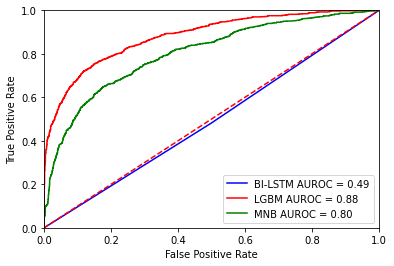

In [157]:
#plt.title('Receiver Operating Characteristic')
plt.plot(fprB, tprB, 'b', label = 'BI-LSTM AUROC = %0.2f' % roc_aucB)
plt.plot(fpr, tpr, 'r', label = 'LGBM AUROC = %0.2f' % roc_aucL)
plt.plot(fpr2, tpr2, 'g', label = 'MNB AUROC = %0.2f' % roc_aucM)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature importance extraction

In [208]:
from sklearn.pipeline import FeatureUnion, Pipeline


classifier = LGBMClassifier(num_leaves= 40)
model = Pipeline(
    [
        ("vectorizer", tfidf),
        ("classifier", classifier),
    ]
)
x_train = Train['x']
y_train = Train[popularity]
model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=6, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
       

In [211]:
feature_names = model.named_steps["vectorizer"].get_feature_names()

In [212]:
coefs = model.named_steps["classifier"].feature_importances_

In [213]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
dfLGBM = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
dfLGBM["abs_value"] = dfLGBM["value"].apply(lambda x: abs(x))
dfLGBM["colors"] = dfLGBM["value"].apply(lambda x: "green" if x > 0 else "red")
dfLGBM = dfLGBM.sort_values("abs_value", ascending=False)

In [226]:
display(Train[x].iloc[147])

' million gmail emails  over million gmail emails perfect for mass sending money making value next orders pay only million email addresses from gmail '

Text(0.5, 0, 'Feature Name')

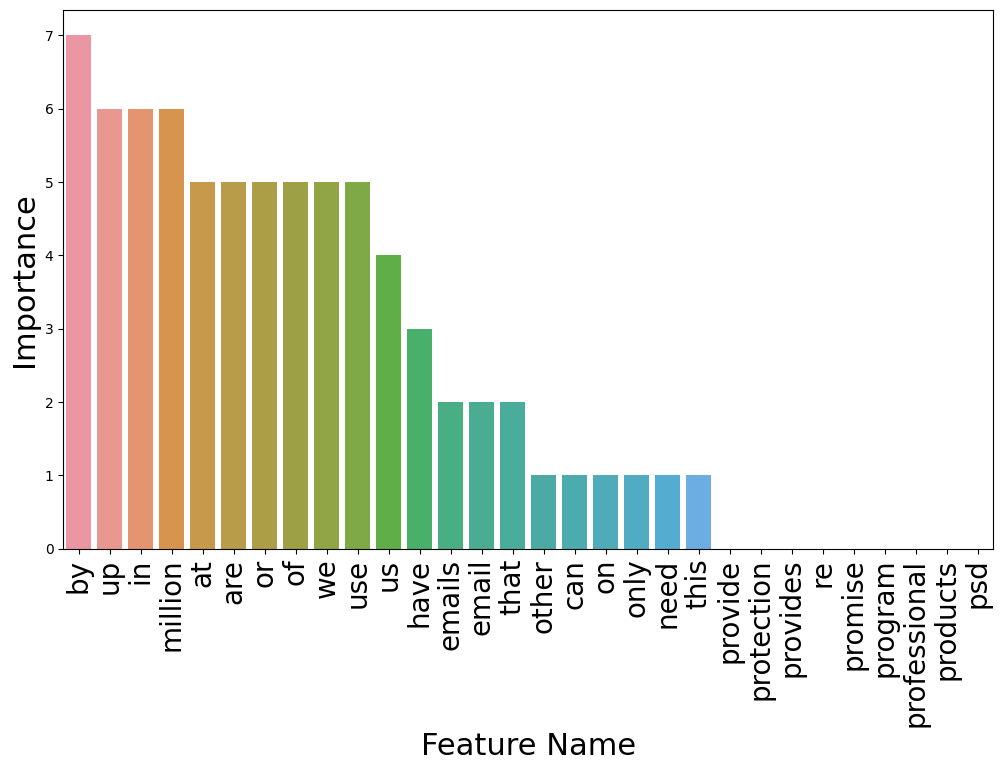

In [214]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=dfLGBM.iloc[21:51])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
#ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Importance", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [217]:
Train = Train.reset_index(drop= True)

In [165]:
Train['both'].loc[Train['both'].str.contains(r"\b(tag)\b") == True]

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


51       extremebits net buffered extremebits net buffe...
68       paypal account credit card cookie session use ...
94       asus serial premium streaming account lifetime...
145      realitygang com lifetime porn premium account ...
146      orbitiptv net premium account lifetime warrant...
                               ...                        
12434    com premium account lifetime warranty product ...
12439    directv com lifetime directv premium account w...
12448    puremature com lifetime porn premium account w...
12471    deezer com lifetime deezer premium account web...
12483    fantasyhd com lifetime porn premium account we...
Name: both, Length: 857, dtype: object

In [173]:
display(Train['both'].iloc[164])

'carders allinall emv included carders best sw read write magstripe chipcards collection best tutorial info graphic template card etc jerm emv exeba much see picture error show port error port error caused writer compatible device feel free ask question'

### Self training MNB

In [29]:
Train = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Train.pkl")
Train.to_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")

In [30]:
zero = False
F1 = []
while zero == False:
  NB_MN=MultinomialNB()
  NB_MN.fit(train_arr,y_train)
  pred=NB_MN.predict(test_arr)
  print(f1_score(y_test,pred))
  F1.append(f1_score(y_test,pred))

  probU = NB_MN.predict_proba(unlabeled_arr)[:, 1]
  dfprobU = pd.DataFrame(data=[probU, X_unlabeld], index=['prediction', 'both']).T
  dfprobU = dfprobU.loc[(dfprobU['prediction'] <= 0.05) | (dfprobU['prediction'] >= 0.95)]
  if len(dfprobU.index) > 0:
    dfprobU.loc[dfprobU['prediction'] < 0.5, popularity] = 0 
    dfprobU.loc[dfprobU['prediction'] >= 0.5, popularity] = 1

    Train = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")
    Train = pd.concat([Train, dfprobU[['both',popularity]]], ignore_index=True, sort=False)
    Train.to_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")
    Train = Oversampling(Train, popularity)

    X_train = Train['both']
    y_train = Train[popularity]
    X_unlabeld = X_unlabeld.reset_index(drop=True)
    X_unlabeld = pd.concat([X_unlabeld, dfprobU['both']]).drop_duplicates(keep=False)
    # X_unlabeld
    #dfprobU['both']

    tfidf=TfidfVectorizer(max_features=50000,min_df=6)
    train_1=tfidf.fit_transform(X_train)
    test_1=tfidf.transform(X_test)
    unlabeled_1 = tfidf.transform(X_unlabeld)

    train_arr=train_1.toarray()
    test_arr=test_1.toarray()
    unlabeled_arr=unlabeled_1.toarray()

  print(len(dfprobU.index))
  zero = (len(dfprobU.index) == 0)

0.6493108728943339
2638
0.6410160627568173
489
0.6432432432432433
98
0.6462848297213623
50
0.6436066848037311
32
0.6450351837372947
22
0.6416988416988416
25
0.6453125
12
0.6467391304347827
31
0.6420323325635103
9
0.6428571428571429
6
0.6430223592906709
12
0.6388567014291232
9
0.6437768240343348
9
0.6425796425796427
6
0.6446345256609641
3
0.6447831184056273
16
0.6446345256609641
7
0.6452623335943618
3
0.6479093395857757
10
0.6459143968871595
3
0.6442641946697567
4
0.6448598130841121
9
0.6441336441336442
9
0.6469443363176333
6
0.6416988416988416
3
0.6446800157047506
9
0.6446345256609641
4
0.6431888544891641
2
0.6401236954000773
3
0.6422732580770728
4
0.6459480723839497
3
0.641946697566628
2
0.6462745098039214
5
0.6427457098283932
7
0.6477228493577268
2
0.6436961628817541
2
0.647196261682243
1
0.6490683229813664
4
0.6454652532391048
6
0.6427727451752658
2
0.6453873102374466
4
0.6463700234192038
2
0.6471981057616416
2
0.6454862456412244
3
0.6441073512252042
4
0.6460454189506657
2
0.6465753

In [213]:
probMNNB = NB_MN.predict_proba(test_arr)[:, 1]

In [201]:
probMNNB

array([0.32764589, 0.58375265, 0.49718831, ..., 0.22578201, 0.36126397,
       0.06151512])

In [ ]:
dfprobMNNB = pd.DataFrame(data=[pred, probMNNB,  y_test], index=['MNNB', 'P_MNNB', 'popular']).T
dfprobMNNB

In [33]:
F1_MNNB = F1

In [ ]:
eval_model(y_test,pred)

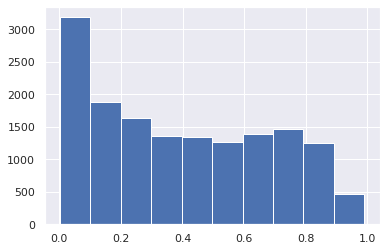

In [822]:
plot = plt.hist(lgbm.predict_proba(unlabeled_arr)[:, 1])

### Self-learning LGBM

In [55]:
Train = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Train.pkl")
Train.to_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")

In [57]:
zero = False
F1 = []
while zero == False:
  lgbm=LGBMClassifier(num_leaves= 40)
  lgbm.fit(train_arr,y_train)
  pred=lgbm.predict(test_arr)
  print(f1_score(y_test,pred))
  F1.append(f1_score(y_test,pred))

  probU = lgbm.predict_proba(unlabeled_arr)[:, 1]
  dfprobU = pd.DataFrame(data=[probU, X_unlabeld], index=['prediction', 'both']).T
  dfprobU = dfprobU.loc[(dfprobU['prediction'] <= 0.05) | (dfprobU['prediction'] >= 0.95)]
  if len(dfprobU.index) > 0:
    dfprobU.loc[dfprobU['prediction'] < 0.5, popularity] = 0 
    dfprobU.loc[dfprobU['prediction'] >= 0.5, popularity] = 1

    Train = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")
    Train = pd.concat([Train, dfprobU[['both',popularity]]], ignore_index=True, sort=False)
    Train.to_pickle("/content/drive/MyDrive/Notebookfiles/Train2.pkl")
    Train = Oversampling(Train, popularity)

    X_train = Train['both']
    y_train = Train[popularity]
    X_unlabeld = X_unlabeld.reset_index(drop=True)
    X_unlabeld = pd.concat([X_unlabeld, dfprobU['both']]).drop_duplicates(keep=False)
    # X_unlabeld
    #dfprobU['both']

    tfidf=TfidfVectorizer(max_features=50000,min_df=6)
    train_1=tfidf.fit_transform(X_train)
    test_1=tfidf.transform(X_test)
    unlabeled_1 = tfidf.transform(X_unlabeld)

    train_arr=train_1.toarray()
    test_arr=test_1.toarray()
    unlabeled_arr=unlabeled_1.toarray()

  print(len(dfprobU.index))
  zero = (len(dfprobU.index) == 0)

0.7311534968210718
2972
0.7338826951042171
582
0.7202762703502714
349
0.7148554336989034
421
0.7279920870425323
252
0.7160493827160493
105
0.7086223984142717
73
0.7199201198202696
42
0.7127924340467895
33
0.7068793619142573
15
0.717
48
0.7127924340467895
29
0.7201195219123505
24
0.722855726326227
10
0.7180771156735103
9
0.7212301587301588
17
0.7089737233515122
6
0.7140726006961711
5
0.7173586793396699
5
0.721327967806841
3
0.7251984126984127
7
0.7150000000000001
4
0.7250996015936254
13
0.7194029850746267
7
0.7230233714569866
4
0.7147117296222663
4
0.7149276085871192
1
0.7154873824839187
5
0.7144977733795151
5
0.7217521154803385
0


In [131]:
F1_LGBM = F1

In [132]:
SemiSupervised = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/SemiSupervised.pkl")

In [133]:
SemiSupervised = pd.concat([SemiSupervised,pd.Series(F1BILSTM)], ignore_index=True, axis=1)

Text(0, 0.5, 'F1-score')

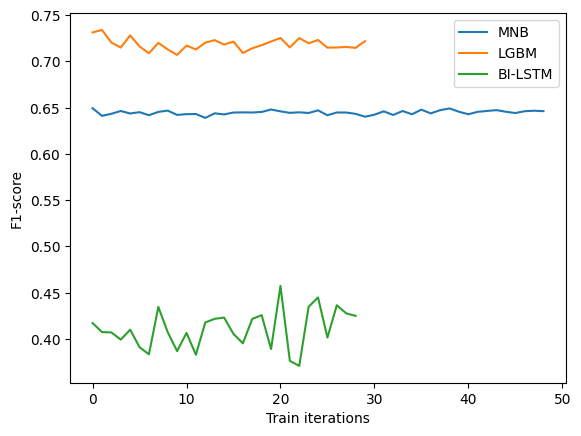

In [183]:
SemiSupervised.columns = ['MNB', 'LGBM', 'BI-LSTM']
#plt.title('Receiver Operating Characteristic')

plot = SemiSupervised.plot()
plot.set_xlabel('Train iterations')
plot.set_ylabel('F1-score')

In [234]:
SemiSupervised.to_pickle("/content/drive/MyDrive/Notebookfiles/SemiSupervised.pkl")

In [249]:
SemiSupervised.describe()

,MNNB,LGBM,BI-LSTM
count,49.000000,30.000000,29.000000
mean,0.644601,0.718511,0.410616
std,0.002215,0.006283,0.021210
min,0.638857,0.706879,0.370850
25%,0.643022,0.714748,0.395251
50%,0.644680,0.717718,0.407380
75%,0.646142,0.721646,0.424942
max,0.649311,0.733883,0.457278


### Data for ensemble

In [715]:
prob = lgbm.predict_proba(test_arr)[:, 1]
print(prob)
print(pred)
print(y_test)


[0.09248781 0.48259651 0.48560682 ... 0.85464582 0.06694447 0.08143092]
[0. 0. 0. ... 1. 0. 0.]
10058    0.0
24251    1.0
30130    1.0
24156    1.0
15608    0.0
        ... 
30183    1.0
30260    0.0
9458     0.0
16749    0.0
9552     0.0
Name: C7, Length: 3134, dtype: float64


In [631]:
type(pred)

numpy.ndarray

In [218]:
probLGBM = lgbm.predict_proba(test_arr)[:, 1]

In [221]:
dfprobLGBM = pd.DataFrame(data=[pred, probLGBM, y_test], index=['LGBM', 'P_LGBM', 'popular']).T
#dfprob['popular'] = Test[popularity]
#dft = Test[popularity].reset_index(drop=True)
#dfprob=dfprob.join(dft)
dfprobLGBM


,LGBM,P_LGBM,popular
0,0.0,0.084222,0.0
1,1.0,0.562314,1.0
2,1.0,0.559901,1.0
3,1.0,0.596884,1.0
4,0.0,0.351433,0.0
...,...,...,...
3129,1.0,0.712326,1.0
3130,0.0,0.476565,0.0
3131,1.0,0.702359,0.0
3132,0.0,0.107948,0.0


In [717]:
dftest = dfprob.loc[dfprob['probability'] >= 0.95].copy()
eval_model(dftest[popularity],dftest['prediction'])
dftest

F1 score of the model
0.9908536585365855
Recall score of the model
1.0
Precision score of the model
0.9818731117824774
Accuracy of the model
0.9818731117824774
Accuracy of the model in percentage
98.187 %


,prediction,probability,C7
7,1.0,0.967475,1.0
26,1.0,0.991755,1.0
46,1.0,0.976333,1.0
60,1.0,0.984735,1.0
66,1.0,0.972154,1.0
...,...,...,...
3056,1.0,0.990104,1.0
3088,1.0,0.988327,1.0
3101,1.0,0.990048,1.0
3113,1.0,0.982567,1.0


### ensemble learning

In [86]:
dfprob = pd.concat([dfprobBILSTM['popular'],dfprobBILSTM['BI-LSTM'], dfprobMNNB['MNNB'], dfprobLGBM['LGBM']], ignore_index=True, axis=1)
dfprob.columns = ['popular', 'BI-LSTM', 'MNNB', 'LGBM']
dfprob.loc[(dfprob['BI-LSTM'] + dfprob['MNNB'] + dfprob['LGBM']) < 2, 'Sum'] = 0 
dfprob.loc[(dfprob['BI-LSTM'] + dfprob['MNNB'] + dfprob['LGBM']) >= 2, 'Sum'] = 1

dfprob['P_BI-LSTM'] = dfprobBILSTM['P_BI-LSTM']
dfprob['P_MNNB'] = dfprobMNNB['P_MNNB']
dfprob['P_LGBM'] = dfprobLGBM['P_LGBM']
dfprob['Mean'] = dfprob.loc[: , "P_BI-LSTM":"P_LGBM"].mean(axis =1)
dfprob.loc[dfprob['Mean'] < 0.5, 'MeanPred'] = 0 
dfprob.loc[dfprob['Mean'] >= 0.5, 'MeanPred'] = 1

dfprob
#eval_model(dfprob['popular'], dfprob['Sum'])

,popular,BI-LSTM,MNNB,LGBM,Sum,P_BI-LSTM,P_MNNB,P_LGBM,Mean,MeanPred,realsum
0,0,1,0.0,0.0,0.0,0.559683,0.342613,0.084222,0.328839,0.0,1.0
1,1,1,1.0,1.0,1.0,0.753709,0.513247,0.562314,0.609757,1.0,3.0
2,1,0,1.0,1.0,1.0,0.161631,0.538307,0.559901,0.419946,0.0,2.0
3,1,1,1.0,1.0,1.0,0.762881,0.680866,0.596884,0.680210,1.0,3.0
4,0,0,0.0,0.0,0.0,0.332812,0.129618,0.351433,0.271288,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3129,1,1,1.0,1.0,1.0,0.758890,0.644750,0.712326,0.705322,1.0,3.0
3130,0,1,1.0,0.0,1.0,0.732313,0.677353,0.476565,0.628744,1.0,2.0
3131,0,0,0.0,1.0,0.0,0.205493,0.170958,0.702359,0.359603,0.0,1.0
3132,0,0,0.0,0.0,0.0,0.289002,0.325289,0.107948,0.240746,0.0,0.0


In [87]:
eval_model(dfprob['popular'], dfprob['MeanPred'])

F1 score of the model
0.7036880033912675
Recall score of the model
0.7552320291173794
Precision score of the model
0.6587301587301587
Accuracy of the model
0.7769623484365029
Accuracy of the model in percentage
77.696 %


In [ ]:
dfprob.to_pickle("/content/drive/MyDrive/Notebookfiles/Ensemble.pkl")

In [190]:
dfprob = pd.read_pickle("/content/drive/MyDrive/Notebookfiles/Ensemble.pkl")

In [191]:
dfprob['realsum'] = dfprob['MNNB'] + dfprob['LGBM']


In [192]:
dfprob.loc[(dfprob['popular'] != dfprob['MeanPred']) & ((dfprob['realsum'] == 0 )| (dfprob['realsum'] == 2)) ]

,popular,BI-LSTM,MNNB,LGBM,Sum,P_BI-LSTM,P_MNNB,P_LGBM,Mean,MeanPred,realsum
2,1,0,1.0,1.0,1.0,0.161631,0.538307,0.559901,0.419946,0.0,2.0
6,1,1,0.0,0.0,0.0,0.789006,0.335162,0.293441,0.472536,0.0,0.0
10,1,0,0.0,0.0,0.0,0.102668,0.194333,0.291287,0.196096,0.0,0.0
15,1,1,0.0,0.0,0.0,0.680602,0.012364,0.244327,0.312431,0.0,0.0
16,0,0,1.0,1.0,1.0,0.460481,0.621274,0.532586,0.538114,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
3102,0,1,1.0,1.0,1.0,0.939324,0.767407,0.619577,0.775436,1.0,2.0
3107,0,0,1.0,1.0,1.0,0.448769,0.750860,0.630452,0.610027,1.0,2.0
3111,0,1,1.0,1.0,1.0,0.593537,0.848040,0.693778,0.711785,1.0,2.0
3118,0,1,1.0,1.0,1.0,0.663275,0.690727,0.647289,0.667097,1.0,2.0


In [196]:
dfprob.loc[(dfprob['popular'] != dfprob['Sum'])]

,popular,BI-LSTM,MNNB,LGBM,Sum,P_BI-LSTM,P_MNNB,P_LGBM,Mean,MeanPred,realsum
6,1,1,0.0,0.0,0.0,0.789006,0.335162,0.293441,0.472536,0.0,0.0
10,1,0,0.0,0.0,0.0,0.102668,0.194333,0.291287,0.196096,0.0,0.0
14,0,1,1.0,0.0,1.0,0.844274,0.815166,0.461299,0.706913,1.0,1.0
15,1,1,0.0,0.0,0.0,0.680602,0.012364,0.244327,0.312431,0.0,0.0
16,0,0,1.0,1.0,1.0,0.460481,0.621274,0.532586,0.538114,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
3118,0,1,1.0,1.0,1.0,0.663275,0.690727,0.647289,0.667097,1.0,2.0
3123,0,1,1.0,0.0,1.0,0.838019,0.638388,0.008869,0.495092,0.0,1.0
3127,1,1,0.0,0.0,0.0,0.546702,0.406550,0.319340,0.424197,0.0,0.0
3128,1,0,0.0,1.0,0.0,0.454713,0.317435,0.910713,0.560954,1.0,1.0


In [93]:
dftest.loc[dftest['popular'] == dftest['LGBM']]

,popular,BI-LSTM,MNNB,LGBM,Sum,P_BI-LSTM,P_MNNB,P_LGBM,Mean,MeanPred,realsum
2,1,0,1.0,1.0,1.0,0.161631,0.538307,0.559901,0.419946,0.0,2.0
14,0,1,1.0,0.0,1.0,0.844274,0.815166,0.461299,0.706913,1.0,2.0
22,0,1,1.0,0.0,1.0,0.692896,0.810986,0.242082,0.581988,1.0,2.0
30,0,1,1.0,0.0,1.0,0.739925,0.548891,0.266870,0.518562,1.0,2.0
45,0,0,1.0,0.0,0.0,0.480347,0.710122,0.323826,0.504765,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3055,1,1,0.0,1.0,1.0,0.658587,0.185695,0.632673,0.492318,0.0,2.0
3068,0,1,0.0,0.0,0.0,0.907247,0.498527,0.341760,0.582511,1.0,1.0
3070,0,1,1.0,0.0,1.0,0.915664,0.985552,0.062940,0.654719,1.0,2.0
3106,0,0,1.0,0.0,0.0,0.417972,0.926339,0.493289,0.612534,1.0,1.0
